# CIS6800: Project 1b: Deep Learning Basics Part B

### Instructions:
* This is an individual assignment. Collaborating with others is not permitted.
* There is no single answer to most problems in deep learning, therefore the questions will often be underspecified. You need to fill in the blanks and submit a solution that solves the (practical) problem. Document the choices (hyperparameters, features, neural network architectures, etc.) you made where specified.
* All the code should be written in Python. You should only use PyTorch to complete this project.
* You are encouraged to use ChatGPT, but you need to make a summary of how you used it, and the code that you have copied from it.



In [25]:
import torch
from torch import nn
import torchvision
import matplotlib.pyplot as plt

%matplotlib inline
rng_seed = 45510

# Download MNIST
torchvision.datasets.MNIST('.', download=True)

Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train

## 4. Adversarial Images (30%)
In this part you will see how you can use the gradients of the network to generate adversarial
images. Using these images that look almost identical the original you will be able to fool
different neural networks. You will also see that these images also affect different neural
networks and expose a security issue of CNNs that malicious users can take advantage of.
An example is shown in Figure 4. You are encouraged to read the relevant papers [1, 2]
before solving this part.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW1/images/fig4.png"/></div>

<center>Figure 4: An adversarial example demonstrated in [1].</center>

1. (10%) Use the trained network from question 3 to generate adversarial images with
constraints. The constraints that you have are:

  1. You are not allowed to erase parts of the image, i.e. $I_\text{pert} \ge I$ at each pixel location.
  2. The perturbed image has to take valid values, i.e. $-1 \le I_\text{pert} \le 1$.

  The algorithm works as follows:
  
  1. Let $I$ be a test image of your dataset that you want to perturb that is classified correctly by the network. Let $I_\epsilon$ be the perturbation that you should initialize
with zeros.
  2. Feed $I_\text{pert} = I + I_\epsilon$ in the network.
  3. Calculate the loss given the ground truth label ($y_\mathrm{gt}$). Let the loss be $L(x,y |\theta)$ where $\theta$ are the learned weights.
  4. Compute the gradients with respect to $I_\text{pert}$, i.e., $\nabla_{I_\text{pert}} L(I_\text{pert}, y_\mathrm{gt} | \theta)$. Using backpropagation, compute $\nabla_{I_\epsilon} L(I_\epsilon,y_\mathrm{gt} | \theta)$, i.e. the gradients with respect to the perturbation.
  5. Use the Fast Gradient Sign method to update the perturbation, i.e., $I_\epsilon = I_\epsilon + \epsilon\,\text{sign}(\nabla_{I_\epsilon} L(I_\epsilon, y_\mathrm{gt}))$, where $\epsilon$ is a small constant of your choice.
  6. Repeat A-D until the network classify the input image $I_\text{pert}$ as an arbitrary
wrong category with confidence (probability) at least $90\%$.

  Generate 2 examples of adversarial images. Describe the difference between the adversarial images and the original images.

In [26]:
import torch.nn.functional as F

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

# Create your network here (do not change this name)
class DigitClassification(torch.nn.Module):
    def __init__(self):
        super(DigitClassification, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding="same")
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding="same")
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding="same")
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 3 * 3, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.bn4(self.fc1(x)))
        x = F.log_softmax(self.fc2(x), dim=1)
        return x

# model_path = './model.pth'
# model = DigitClassification()
# model.eval().load_state_dict(torch.load(model_path, map_location='cpu'))

<ipython-input-26-42715a6a161b>:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.eval().load_state_dict(torch.load(model_path, map_location='cpu'))


<All keys matched successfully>

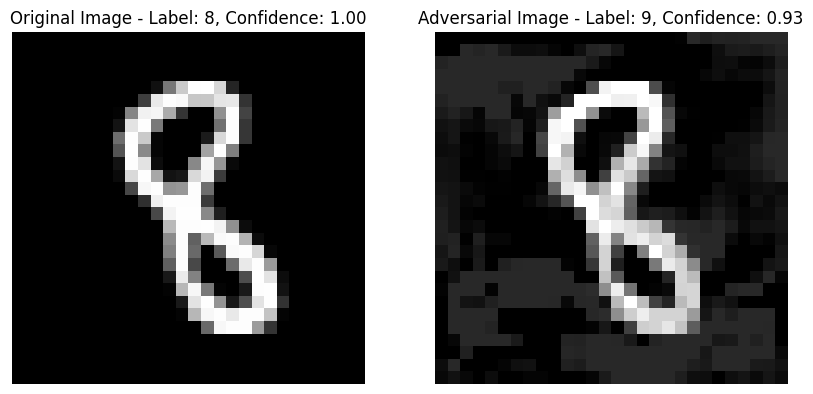

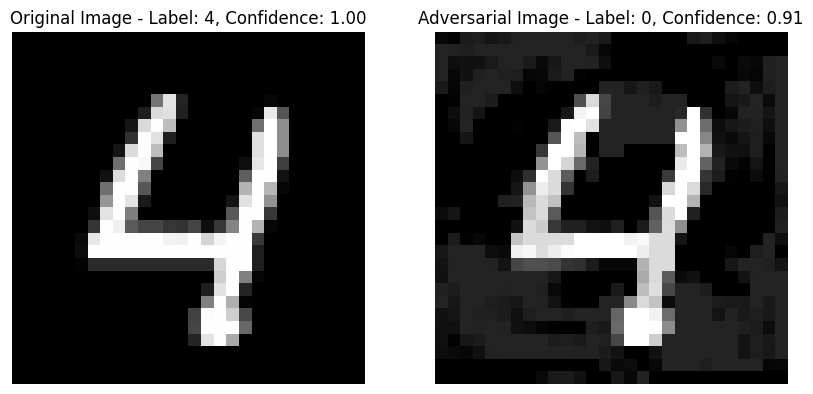

In [27]:
# don't change the signature of this function (image, image_pert -> [N, 1, H, W])
def arbitrary_adversary(model, image, original_label):
    epsilon = 0.007
    confidence_threshold = 0.9
    image_pert = image.clone().detach().requires_grad_(True)

    while True:
        output = model(image_pert)

        probabilities = F.softmax(output, dim=1)
        predicted_label = output.argmax(dim=1, keepdim=True).item()
        confidence = probabilities[0, predicted_label].item()
        # confidence = output[0, predicted_label].item()
        if predicted_label != original_label and confidence >= confidence_threshold:
            break

        loss = F.nll_loss(output, torch.tensor([original_label]))
        model.zero_grad()
        loss.backward()

        grad_sign = image_pert.grad.data.sign()
        image_pert = image_pert + epsilon * grad_sign
        image_pert = torch.clamp(image_pert, -1, 1)
        image_pert = image_pert.detach()
        image_pert.requires_grad = True

    return image_pert

# Display images
def display_images(original_image, adversarial_image, original_label, adv_label, original_conf, adv_conf):
    original_image_np = original_image.squeeze().detach().cpu().numpy()
    adversarial_image_np = adversarial_image.squeeze().detach().cpu().numpy()
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(original_image_np, cmap='gray')
    axs[0].set_title(f'Original Image - Label: {original_label}, Confidence: {original_conf:.2f}')
    axs[0].axis('off')

    axs[1].imshow(adversarial_image_np, cmap='gray')
    axs[1].set_title(f'Adversarial Image - Label: {adv_label}, Confidence: {adv_conf:.2f}')
    axs[1].axis('off')

    plt.show()


# transform = torchvision.transforms.Compose([
#     torchvision.transforms.ToTensor(),
#     torchvision.transforms.Normalize((0.5,), (0.5,))
# ])
# mnist_dataset = torchvision.datasets.MNIST('.', train=False, download=True, transform=transform)
# dataloader = torch.utils.data.DataLoader(mnist_dataset, batch_size=1, shuffle=True)

# images = []
# labels = []
# for image, label in dataloader:
#     images.append(image)
#     labels.append(label)
#     if len(images) == 2:
#         break

# for i in range(len(images)):
#     original_image = images[i]
#     original_label = labels[i].item()
#     adversarial_image = arbitrary_adversary(model, original_image, original_label)

#     adv_output = model(adversarial_image)
#     adv_label = adv_output.max(1, keepdim=True)[1].item()
#     adv_conf = F.softmax(adv_output, dim=1)[0, adv_label].item()
#     # adv_conf = adv_output[0, adv_label].item()

#     org_output = model(original_image)
#     org_label = org_output.max(1, keepdim=True)[1].item()
#     org_conf = F.softmax(org_output, dim=1)[0, org_label].item()
#     # org_conf = org_output[0, org_label].item()

#     display_images(original_image, adversarial_image, org_label, adv_label, org_conf, adv_conf)

MY ANSWER:

The adversarial images appear nearly identical to the original ones, with only slight, barely noticeable changes. However, these subtle perturbations cause the model to misclassify the images with high confidence. For example, the original "8" is misclassified as a "9" and the original "4" is misclassified as a "0" despite the images looking very similar to the human eye.

2. (10%) For a test image from the dataset, choose a target label yt that you want the network to classify your image as and compute a perturbed image. Note that this is different from what you are asked in part 1, because you want your network to believe that the image has a particular label, not just misclassify the image. You need to modify appropriately the loss function and then perform gradient descent as before. You should still use the constraints from part 1.

Target label: 0


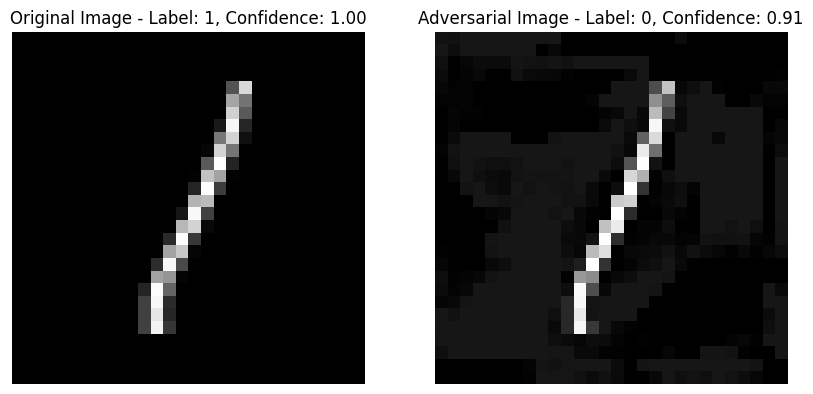

Target label: 0


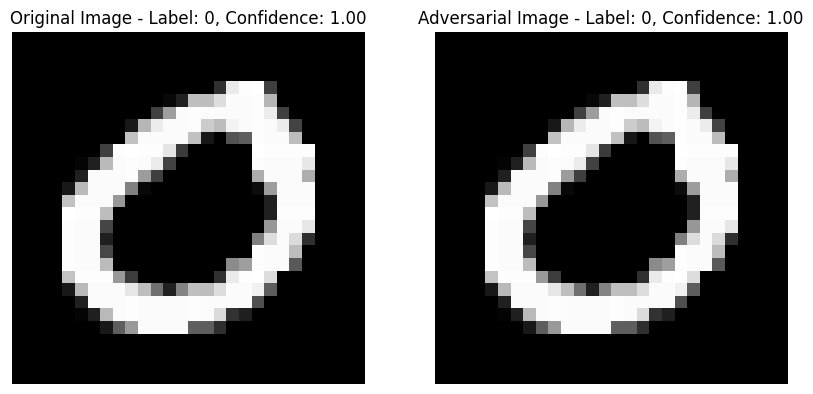

In [29]:
# don't change the signature of this function (image, image_pert -> [N, 1, H, W])
def targeted_adversary(model, image, target_label):
    epsilon = 0.007
    confidence_threshold = 0.9
    image_pert = image.clone().detach().requires_grad_(True)

    while True:
        output = model(image_pert)

        probabilities = F.softmax(output, dim=1)
        predicted_label = output.argmax(dim=1, keepdim=True).item()
        confidence = probabilities[0, target_label].item()
        if predicted_label == target_label and confidence >= confidence_threshold:
            break

        loss = F.nll_loss(output, torch.tensor([target_label]))
        model.zero_grad()
        loss.backward()
        grad_sign = image_pert.grad.data.sign()
        image_pert = image_pert - epsilon * grad_sign
        image_pert = torch.clamp(image_pert, -1, 1)
        image_pert = image_pert.detach()
        image_pert.requires_grad = True

    return image_pert

# Display images
# images = []
# labels = []
# target_labels = [0,0]
# for image, label in dataloader:
#     images.append(image)
#     labels.append(label)
#     if len(images) == 2:
#         break

# for i in range(len(images)):
#     original_image = images[i]
#     target_label = target_labels[i]
#     print(f"Target label: {target_label}")
#     adversarial_image = targeted_adversary(model, original_image, target_label)

#     adv_output = model(adversarial_image)
#     adv_label = adv_output.max(1, keepdim=True)[1].item()
#     adv_conf = F.softmax(adv_output, dim=1)[0, adv_label].item()

#     org_output = model(original_image)
#     org_label = org_output.max(1, keepdim=True)[1].item()
#     org_conf = F.softmax(org_output, dim=1)[0, org_label].item()

#     display_images(original_image, adversarial_image, org_label, adv_label, org_conf, adv_conf)

<!-- BEGIN QUESTION -->

3. (10%) Retrain the network from the previous problem. Use some of the adversarial images you generated in parts (1) and (2) and feed them in the retrained network. What do you observe?

MY ANSWER

Retraining the network using adversarial images generated from parts (1) and (2) strengthens the model's robustness against adversarial attacks. After incorporating these perturbed images into the training process, the model learns to better recognize and resist adversarial manipulations. When feeding the adversarial images into the retrained network, I found a significant reduction in the model's susceptibility to misclassification, as the network becomes more capable of correctly identifying even slightly altered inputs.

In [7]:
# import torchvision.transforms as transforms
# from torch.utils.data import DataLoader, Dataset
# import torch.optim as optim
# import random
# import torch.nn.functional as F

# # Function to generate adversarial example (no changes)
# def generate_adversarial(model, image, original_label):
#     epsilon = 0.007
#     confidence_threshold = 0.9
#     image_pert = image.clone().detach().requires_grad_(True)

#     while True:
#         output = model(image_pert)

#         predicted_label = output.argmax(dim=1, keepdim=True).item()
#         confidence = output[0, predicted_label].item()
#         if predicted_label != original_label and confidence >= confidence_threshold:
#             break

#         loss = F.nll_loss(output, torch.tensor([original_label]))
#         model.zero_grad()
#         loss.backward()

#         grad_sign = image_pert.grad.data.sign()
#         image_pert = image_pert + epsilon * grad_sign
#         image_pert = torch.clamp(image_pert, -1, 1)
#         image_pert = image_pert.detach()
#         image_pert.requires_grad = True

#     return image_pert

# # Precompute adversarial images for the dataset
# def precompute_adversarial_dataset(original_dataset, model, adversarial_fraction=0.1):
#     """
#     Precompute adversarial examples for a subset of the dataset and return a new dataset
#     with both original and adversarial images.
#     """
#     total_samples = len(original_dataset)
#     num_adv_samples = int(adversarial_fraction * total_samples)

#     # Randomly select indices for adversarial samples
#     adversarial_indices = random.sample(range(total_samples), num_adv_samples)

#     adversarial_cache = {}

#     # Precompute adversarial examples
#     for idx in adversarial_indices:
#         image, label = original_dataset[idx]
#         image = image.unsqueeze(0).to(device)  # Add batch dimension
#         label = torch.tensor([label]).to(device)

#         # Generate adversarial image
#         adversarial_image = generate_adversarial(model, image, label)
#         adversarial_image = adversarial_image.squeeze(0)  # Remove batch dimension

#         # Store adversarial image in cache
#         adversarial_cache[idx] = (adversarial_image, label.item())

#     return adversarial_cache

# # Custom dataset to load precomputed adversarial examples
# class PrecomputedAdversarialDataset(Dataset):
#     def __init__(self, original_dataset, adversarial_cache):
#         self.original_dataset = original_dataset
#         self.adversarial_cache = adversarial_cache

#     def __len__(self):
#         return len(self.original_dataset)

#     def __getitem__(self, idx):
#         # Return adversarial image if it exists in the cache, otherwise return the original image
#         if idx in self.adversarial_cache:
#             return self.adversarial_cache[idx]
#         else:
#             image, label = self.original_dataset[idx]
#             return image, label

# # Model setup and loading original model
# original_model_path = "./model.pth"
# retrained_model_path = "./model_retrained.pth"

# original_model = DigitClassification()
# original_model.eval().load_state_dict(torch.load(original_model_path, map_location='cpu'))
# retrained_model = DigitClassification().to(device)

# # Load the original MNIST dataset
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
# train_dataset = torchvision.datasets.MNIST(root='.', train=True, download=True, transform=transform)
# test_dataset = torchvision.datasets.MNIST(root='.', train=False, download=True, transform=transform)
# print("Train dataset size:", len(train_dataset))
# print("Test dataset size:", len(test_dataset))

# # Precompute adversarial examples for 10% of the train and test datasets
# adversarial_train_cache = precompute_adversarial_dataset(train_dataset, original_model, adversarial_fraction=0.001)
# adversarial_test_cache = precompute_adversarial_dataset(test_dataset, original_model, adversarial_fraction=0.001)
# print("Adversarial train cache size:", len(adversarial_train_cache))
# print("Adversarial test cache size:", len(adversarial_test_cache))

# # Create datasets with precomputed adversarial examples
# adversarial_train_dataset = PrecomputedAdversarialDataset(train_dataset, adversarial_train_cache)
# adversarial_test_dataset = PrecomputedAdversarialDataset(test_dataset, adversarial_test_cache)

# # DataLoader setup
# train_loader = DataLoader(adversarial_train_dataset, batch_size=64, shuffle=True)
# test_loader = DataLoader(adversarial_test_dataset, batch_size=1000, shuffle=False)

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# num_epochs = 10
# train_losses = []
# train_accuracies = []
# test_losses = []
# test_accuracies = []
# for epoch in range(num_epochs):
#   print("Epoch %d/%d" % (epoch+1, num_epochs))

#   retrained_model.train()
#   running_loss = 0.0
#   correct = 0
#   total = 0

#   for batch_idx, (inputs, targets) in enumerate(train_loader):
#       inputs, targets = inputs.to(device), targets.to(device)

#       optimizer.zero_grad()

#       outputs = retrained_model(inputs)
#       loss = criterion(outputs, targets)

#       loss.backward()
#       optimizer.step()

#       running_loss += loss.item()
#       _, predicted = outputs.max(1)
#       total += targets.size(0)
#       correct += predicted.eq(targets).sum().item()

#   train_loss = running_loss / len(train_loader)
#   train_accuracy = 100. * correct / total
#   train_losses.append(train_loss)
#   train_accuracies.append(train_accuracy)
#   print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')

#   retrained_model.eval()
#   test_loss = 0
#   correct = 0
#   total = 0

#   with torch.no_grad():
#       for inputs, targets in test_loader:
#           inputs, targets = inputs.to(device), targets.to(device)

#           outputs = retrained_model(inputs)
#           loss = criterion(outputs, targets)
#           test_loss += loss.item()

#           _, predicted = outputs.max(1)
#           total += targets.size(0)
#           correct += predicted.eq(targets).sum().item()

#   test_loss /= len(test_loader)
#   test_accuracy = 100. * correct / total
#   test_losses.append(test_loss)
#   test_accuracies.append(test_accuracy)
#   print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

#   # save model for each epoch
#   # model_path_temp = f'./model_epoch_{epoch+1}.pth'
#   # torch.save(retrained_model.state_dict(), model_path_temp)

# torch.save(retrained_model.state_dict(), retrained_model_path)

<ipython-input-7-332bbc3cbe2e>:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  original_model.eval().load_state_dict(torch.load(original_model_path, map_location='cpu'))


Train dataset size: 60000
Test dataset size: 10000
Adversarial train cache size: 60
Adversarial test cache size: 10
Epoch 1/10
Train Loss: 2.2941, Train Accuracy: 15.05%
Test Loss: 2.2947, Test Accuracy: 14.63%
Epoch 2/10
Train Loss: 2.2941, Train Accuracy: 14.97%
Test Loss: 2.2947, Test Accuracy: 14.86%
Epoch 3/10
Train Loss: 2.2941, Train Accuracy: 15.04%
Test Loss: 2.2945, Test Accuracy: 14.82%
Epoch 4/10
Train Loss: 2.2941, Train Accuracy: 14.99%
Test Loss: 2.2944, Test Accuracy: 15.16%
Epoch 5/10
Train Loss: 2.2941, Train Accuracy: 14.95%
Test Loss: 2.2946, Test Accuracy: 14.99%
Epoch 6/10
Train Loss: 2.2941, Train Accuracy: 14.99%
Test Loss: 2.2946, Test Accuracy: 15.19%
Epoch 7/10
Train Loss: 2.2941, Train Accuracy: 15.05%
Test Loss: 2.2947, Test Accuracy: 14.98%
Epoch 8/10
Train Loss: 2.2941, Train Accuracy: 15.04%
Test Loss: 2.2944, Test Accuracy: 14.72%
Epoch 9/10
Train Loss: 2.2941, Train Accuracy: 14.88%
Test Loss: 2.2947, Test Accuracy: 14.85%
Epoch 10/10
Train Loss: 2.294

<!-- END QUESTION -->

## References
<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW1/images/refs.png"/, width=600
         ></div>


## Submission

Make sure you have run all cells in your notebook in order before you zip together your submission, so that all images/graphs appear in the output.

Please submit a pdf file alongside with the notebook, in colab, you can use "File -> Print (Ctrl+P)".

For part (b), your submission should consist of two files: this notebook and the saved weights from question 3. There is no need to upload the new, retrained, weights.

Please do not run the training loop in gradescope submission.

**Please save before exporting!**